In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use('ggplot')

prices = pd.read_excel('data/generated_average_prices.xlsx')
precipitations = pd.read_excel('data/weather_merignac.xlsx', sheet_name='precipitations_mm', index_col=0)
temp_maximals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_maximals', index_col=0)
temp_minimals = pd.read_excel('data/weather_merignac.xlsx', sheet_name='temp_minimals', index_col=0)
frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='frost_days_count', index_col=0)
insulation = pd.read_excel('data/weather_merignac.xlsx', sheet_name='insulation', index_col=0)
severe_frost_days = pd.read_excel('data/weather_merignac.xlsx', sheet_name='severe_frost_days_count', index_col=0)

According to 'The Demand for Expert Opinion: Bordeaux Wine', some important factors are:
- Age of Wine
- Average temperature in the summer (Apr-Sep)
- Harvest rain (Aug-Sep)
- Winter rain (Oct-Mar)

We are going to try and recreate the results of the regression that was run in the paper.

# Feature engineering - recreating the Ashenfelter experiment

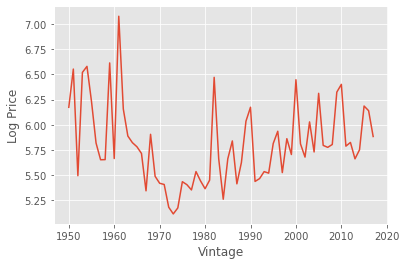

In [2]:
y = prices.set_index('Vintage', drop=True)
y['Log Price'] = np.log(y['Price'])
y=y[['Log Price']]
sns.lineplot(data=y['Log Price'])
plt.show()

In [3]:
X = pd.DataFrame(index = precipitations.index)
X['Harvest Rain'] = precipitations['Aou'] + precipitations['Sep']

X['Winter Rain'] = precipitations.shift(1)['Oct'] + precipitations.shift(1)['Nov']\
+ precipitations.shift(1)['Dec'] + precipitations['Jan']+ precipitations['Fev'] + precipitations['Mar']

X['Summer Temperature'] = (temp_maximals['Avr'] + temp_maximals['Mai'] + temp_maximals['Jui'] + temp_maximals['Juil']\
+ temp_maximals['Aou'] + temp_maximals['Sep'] + temp_minimals['Avr'] + temp_minimals['Mai'] + temp_minimals['Jui'] + temp_minimals['Juil']\
+ temp_minimals['Aou'] + temp_minimals['Sep']) / 12


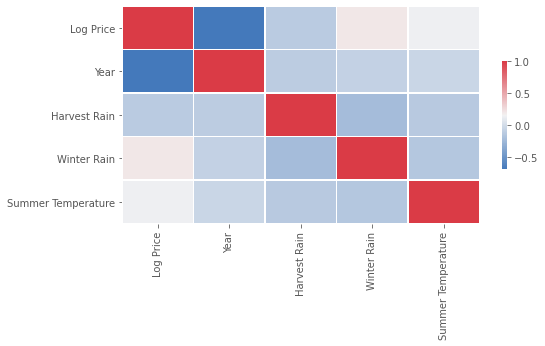

In [4]:
oldest_vintage=1950
newest_vintage=1980
y_ex = y.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
combined = pd.concat([y_ex[['Log Price']], X_ex], axis=1)
corr = combined.corr()

plt.figure(figsize=(8,4))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, linewidth=.5, cbar_kws={"shrink": .5})
plt.show()

## Building the model

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

model = LinearRegression(normalize=False)
oldest_vintage=1950
newest_vintage=1980

y_ex = y.loc[oldest_vintage:newest_vintage+1,'Log Price'].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
model.fit(X_ex, y_ex)
for i in range(len(X_ex.columns.to_list())):  
    print(X_ex.columns.to_list()[i], model.coef_[i])
    
    
print('\nModel Pearson In-sample Score: ',r2_score(model.predict(X_ex),y_ex))
print('Model Spearman In-sample Score: ',spearmanr(model.predict(X_ex),y_ex)[0])

Year -0.035644247355236795
Harvest Rain -0.0009669461978413117
Winter Rain 0.0006028554662033316
Summer Temperature 0.08955519856767227

Model Pearson In-sample Score:  0.11196665983668042
Model Spearman In-sample Score:  0.7305718475073313


This score is quite good, but not as impressive as in the original Ashenfelter experiment. This could be due to several factors: the prices were not gathered the same way, the corpus of wines is different, the prices have changed since the experiment. Let us now try to see how this models coefficients have changed over time.

In [6]:
from sklearn.preprocessing import StandardScaler

def model_tester(X, y):
    coefficients = pd.DataFrame(0, index = X.columns.to_list(), columns=range(1950,1997))
    r2_scores = []
    predictions = pd.DataFrame(index=X.index, columns=['Log Price'])
    spearman_scores = []
    X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

    for column in coefficients:
        oldest_vintage = column
        newest_vintage = column + 20

        y_ex = y.loc[oldest_vintage:newest_vintage,'Log Price'].reset_index(drop=True)
        X_ex = X.loc[oldest_vintage:newest_vintage,:].reset_index(drop=True)

        model.fit(X_ex,y_ex)
        coefs = pd.Series(model.coef_)
        coefs.index = coefficients.index
        coefficients[column] = coefs
        r2_scores.append(r2_score(model.predict(X_ex),y_ex))
        spearman_scores.append(spearmanr(model.predict(X_ex),y_ex)[0])
        predictions.loc[newest_vintage+1] = model.predict(X.loc[newest_vintage+1:newest_vintage+1, :])
    
    coefficients = coefficients.transpose()
    display(coefficients.head())
    return coefficients, r2_scores, spearman_scores, predictions

#We will need ticks corresponding to our rolling windows for the graphs
labels = [str(i)+'-'+str(i+20) for i in range(1950,1997,5)]

,Harvest Rain,Winter Rain,Summer Temperature
1950,-0.097253,0.049282,0.087821
1951,-0.089047,0.067429,0.035950
1952,-0.077163,0.022579,0.183272
1953,-0.058315,0.095038,0.147756
1954,-0.047396,0.074183,0.151722


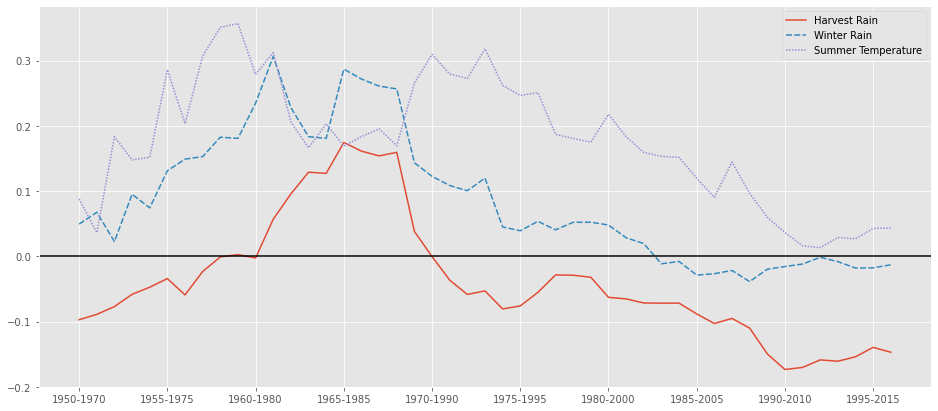

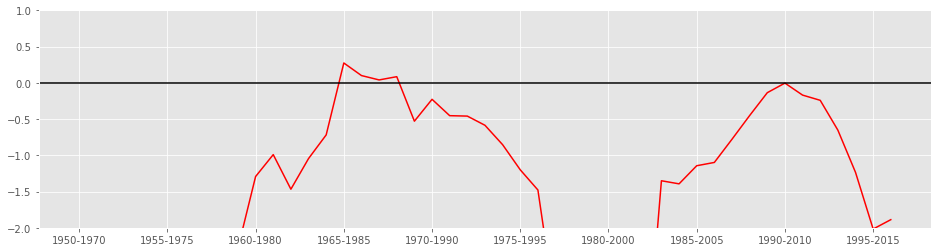

Average in-sample R2 score over the whole period:  -2.1829583286039442


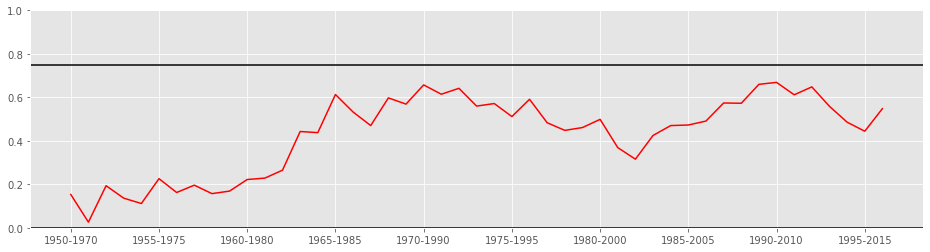

Average in-sample Spearman R over the whole period:  0.4310859353412544


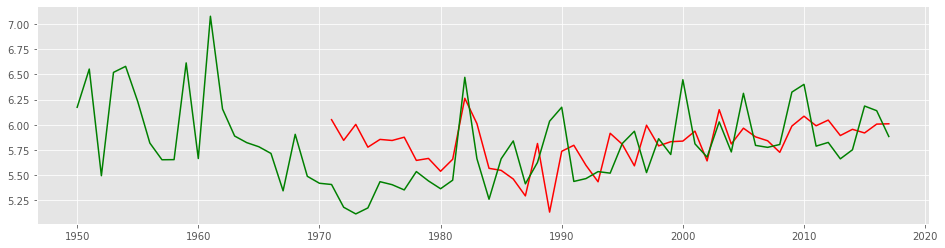

Average out-sample Spearman R over the whole period:  0.4229492650545281


In [7]:
coefficients, r2_scores, spearman_scores, predictions = model_tester(X, y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients).axhline(0., color='black')
plt.xticks(range(1950,1997,5),labels=labels)
plt.show()

plt.figure(figsize=(16,4))
sns.lineplot(data=r2_scores, color='red').axhline(0., color='black')
plt.xticks(range(0,46,5),labels=labels)
plt.ylim((-2,1))
plt.plot(0)
plt.savefig('views/In-sample_R2_simple_regression.png')
plt.show()
print('Average in-sample R2 score over the whole period: ',np.mean(r2_scores))

plt.figure(figsize=(16,4))
sns.lineplot(data=spearman_scores, color='red').axhline(0., color='black')
plt.xticks(range(0,46,5),labels=labels)
plt.ylim((0,1))
plt.plot(0)
plt.axhline(0.75, color='black')

plt.savefig('views/In-sample_Spearman_R_simple_regression.png')
plt.show()
print('Average in-sample Spearman R over the whole period: ',np.mean(spearman_scores))


plt.figure(figsize=(16,4))
plt.plot(predictions, color='red')
plt.plot(y, color='green')

plt.savefig('views/Spearman_R_simple_regression.png')
plt.show()

print('Average out-sample Spearman R over the whole period: ',spearmanr(predictions.loc[1981:2017], y.loc[1981:2017])[0])

# Adding new variables

In [125]:
X = pd.DataFrame(index = precipitations.index)

X['Harvest Rain'] = precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou'] + precipitations['Sep']
X['Spring Rain'] = precipitations['Mar']+precipitations['Avr']

X['Winter Rain'] = precipitations.shift(1)['Oct'] + precipitations.shift(1)['Nov']\
+ precipitations.shift(1)['Dec'] + precipitations['Jan']+ precipitations['Fev'] + precipitations['Mar']

#X['Insulation'] = insulation.iloc[:,0]

X['Winter Temperature'] = \
    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
    (temp_maximals['Fev'] + temp_minimals['Fev'])+\
    (temp_maximals['Mar'] + temp_minimals['Mar'])
X['Early Summer Temperature'] = \
    (temp_maximals['Avr'] + temp_minimals['Avr']) +\
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui']) +\
    (temp_maximals['Juil'] + temp_minimals['Juil'])

X['Late Summer Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])

X['Frost Days Winter'] = frost_days.shift(1)['Nov']+frost_days.shift(1)['Dec'] + frost_days['Jan']
#X['Frost Days Early'] = frost_days['Fev']+frost_days['Mar']
X['Frost Days Late'] = frost_days['Avr']+ 2*(frost_days['Mai'] + frost_days['Jui'] + frost_days['Juil'])

#X['Severe Frost Days'] = (severe_frost_days['Sep'].shift(1).fillna(0) + severe_frost_days['Oct'].shift(1).fillna(0) + severe_frost_days['Nov'].shift(1).fillna(0))*3 + severe_frost_days['Dec'].shift(1).fillna(0)*2 + severe_frost_days['Jan'] + severe_frost_days['Fev'] + severe_frost_days['Mar']*2 + severe_frost_days['Mar']*3

X['Frost Days Prev Fall'] = 2*frost_days['Sep'].shift(1).fillna(0)+ 2*frost_days['Oct'].shift(1).fillna(0)+ frost_days['Nov'].shift(1).fillna(0) + frost_days['Dec'].shift(1).fillna(0)

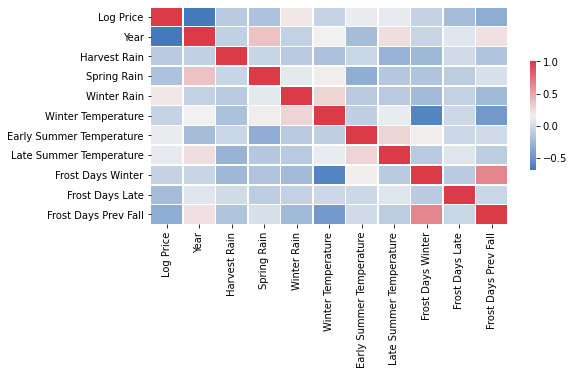

In [126]:
y_ex = y.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index()
combined = pd.concat([y_ex[['Log Price']], X_ex], axis=1)

corr = combined.corr()

plt.figure(figsize=(8,4))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, linewidth=.5, cbar_kws={"shrink": .5})
plt.show()

,Year,Harvest Rain,Spring Rain,Winter Rain,Winter Temperature,Early Summer Temperature,Late Summer Temperature,Frost Days Winter,Frost Days Late,Frost Days Prev Fall
1950,-0.044216,-0.050503,0.035296,0.070152,-0.101106,-0.157569,0.294067,-0.009456,-0.047119,-0.094492
1951,-0.040675,-0.035850,0.020660,0.070022,-0.109632,-0.188889,0.311162,0.007881,-0.051540,-0.119763
1952,-0.034515,-0.059743,0.013683,0.029199,-0.127211,-0.164837,0.298099,0.018203,-0.051954,-0.188161
1953,-0.062060,-0.207257,0.143118,0.023144,-0.127056,0.293427,-0.003039,-0.132752,0.028978,-0.045293
1954,-0.061581,-0.209679,0.147388,0.018193,-0.121558,0.301722,-0.008859,-0.142971,0.030823,-0.035319


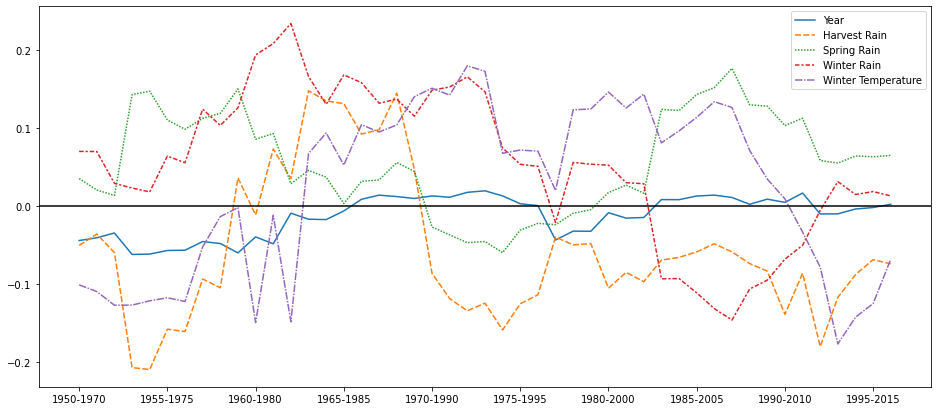

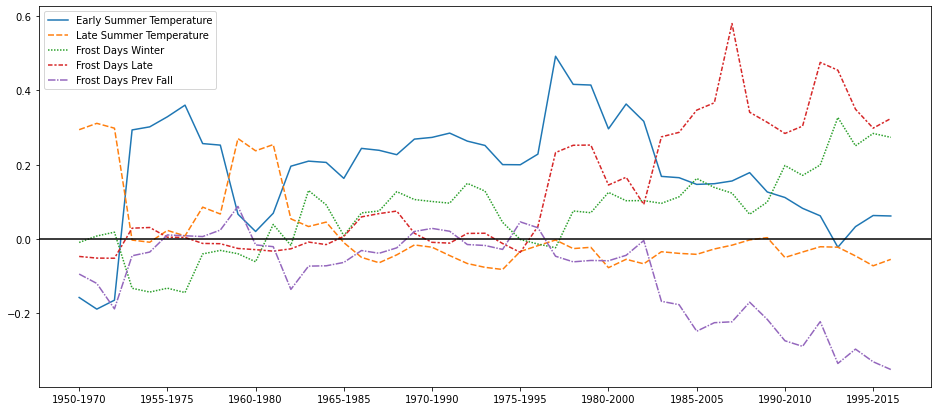

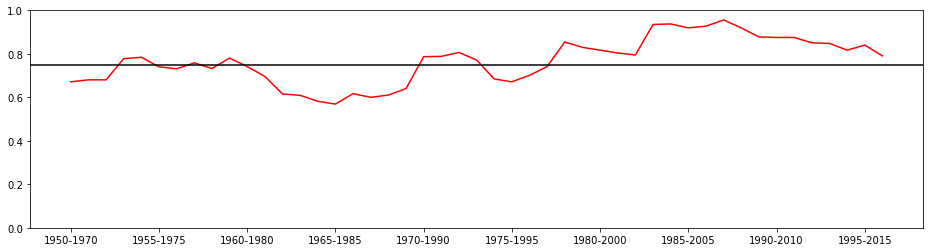

Average in-sample R2 score over the whole period:  0.36611293810128026
Average in-sample spearman score over the whole period:  0.7668140370268028
Average out-sample Spearman R over the whole period:  0.34732100521574205


In [127]:
coefficients, r2_scores, spearman_scores, predictions = model_tester(X,y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:5]).axhline(0., color='black')
plt.xticks(range(1950,1996,5),labels=labels)
plt.show()

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,5:]).axhline(0., color='black')
plt.xticks(range(1950,1996,5),labels=labels)
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(spearman_scores, color='red')
plt.axhline(0.75, color='black')
plt.ylim((0,1))

plt.xticks(range(0,46,5),labels=labels)
plt.show()
print('Average in-sample R2 score over the whole period: ',np.mean(r2_scores))
print('Average in-sample spearman score over the whole period: ',np.mean(spearman_scores))

print('Average out-sample Spearman R over the whole period: ',spearmanr(predictions.loc[1981:2017], y.loc[1981:2017])[0])

This is better, but there is too many features: 11 features for predicting a 30 dimensional vector.
Let us rank the features according to their average importance.

In [128]:
from sklearn.metrics import r2_score

display(y)
for column in X.columns:
    print(column, ':',r2_score(y.loc[1950:2015, 'Log Price'].values, X.loc[1950:2015, column].values))

,Log Price
Vintage,
1950,6.173414
1951,6.553755
1952,5.493061
1953,6.520884
1954,6.580639
...,...
2015,6.186129
2016,6.139802
2017,5.883108


Harvest Rain : -701858.6179358084
Spring Rain : -125687.36168106696
Winter Rain : -1841968.6236625288
Winter Temperature : -18323.70939991929
Early Summer Temperature : -99665.21016079072
Late Summer Temperature : -31497.42080340325
Frost Days Winter : -1714.1694574391913
Frost Days Late : -167.74057527496416
Frost Days Prev Fall : -490.1804268026619


# Improved model

In [30]:
X = pd.DataFrame(index = precipitations.index)

# Ashenfelter variables
X['Harvest Rain'] = precipitations['Aou'] + precipitations['Sep']

X['Winter Rain'] = precipitations.shift(1)['Oct'] + precipitations.shift(1)['Nov']\
+ precipitations.shift(1)['Dec'] + precipitations['Jan']+ precipitations['Fev'] + precipitations['Mar']

#X['Summer Temperature'] = (temp_maximals['Avr'] + temp_maximals['Mai'] + temp_maximals['Jui'] + temp_maximals['Juil']\
#+ temp_maximals['Aou'] + temp_maximals['Sep'] + temp_minimals['Avr'] + temp_minimals['Mai'] + temp_minimals['Jui'] + temp_minimals['Juil']\
#+ temp_minimals['Aou'] + temp_minimals['Sep']) / 12
#

#X['Harvest Rain'] =  precipitations['Mai']+precipitations['Jui']+precipitations['Juil']+precipitations['Aou']+ precipitations['Sep']*2
##X['Square Harvest Rain'] =  X['Harvest Rain']**2
#
#X['Winter Rain'] =  precipitations.shift(1)['Dec'] # really important
##X['Square Winter Rain'] =  X['Winter Rain']**2
#
X['Summer Temperature'] = \
    (temp_maximals['Mai'] + temp_minimals['Mai'])+\
    (temp_maximals['Jui'] + temp_minimals['Jui'])*2+\
    (temp_maximals['Juil'] + temp_minimals['Juil'])
##X['Square Summer Temperature'] = X['Summer Temperature']**2


#X['Winter Temperature'] = \
#    (temp_maximals.shift(1)['Dec'] + temp_minimals.shift(1)['Dec'])+\
#    (temp_maximals['Jan'] + temp_minimals['Jan'])+\
#    (temp_maximals['Fev'] + temp_minimals['Fev'])
#X['Square Winter Temperature'] = X['Winter Temperature']**2


X['Harvest Temperature'] = \
                    (temp_maximals['Aou'] + temp_minimals['Aou'])+\
                    (temp_maximals['Sep'] + temp_minimals['Sep'])
#

#X['Square Harvest Temperature'] = X['Harvest Temperature']**2

#X['Frost Days Late'] = frost_days['Avr']+ frost_days['Mai'] + frost_days['Jui']

#X['Square Frost Days'] = X['Frost Days']**2

#X['Insulation'] = insulation.iloc[:,0] # negative on mean r2 and bad scores


#X['Frost Days Prev Fall'] = 2*frost_days['Sep'].shift(1).fillna(0)+ 2*frost_days['Oct'].shift(1).fillna(0)+ frost_days['Nov'].shift(1).fillna(0) + frost_days['Dec'].shift(1).fillna(0)

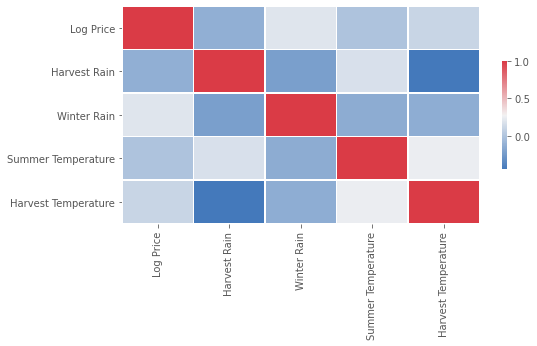

In [31]:
y_ex = y.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
X_ex = X.loc[oldest_vintage:newest_vintage+1,:].reset_index(drop=True)
combined = pd.concat([y_ex[['Log Price']], X_ex], axis=1)

corr = combined.corr()

plt.figure(figsize=(8,4))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap, linewidth=.5, cbar_kws={"shrink": .5})
plt.savefig('views/heatmap.png', bbox_inches='tight')
plt.show()

,Harvest Rain,Winter Rain,Summer Temperature,Harvest Temperature
1950,-0.030001,0.066377,-0.136527,0.238868
1951,0.032139,0.090993,-0.333506,0.363898
1952,0.042256,0.051780,-0.237123,0.426858
1953,0.031885,0.130564,-0.325024,0.347306
1954,0.018410,0.109491,-0.257240,0.294541


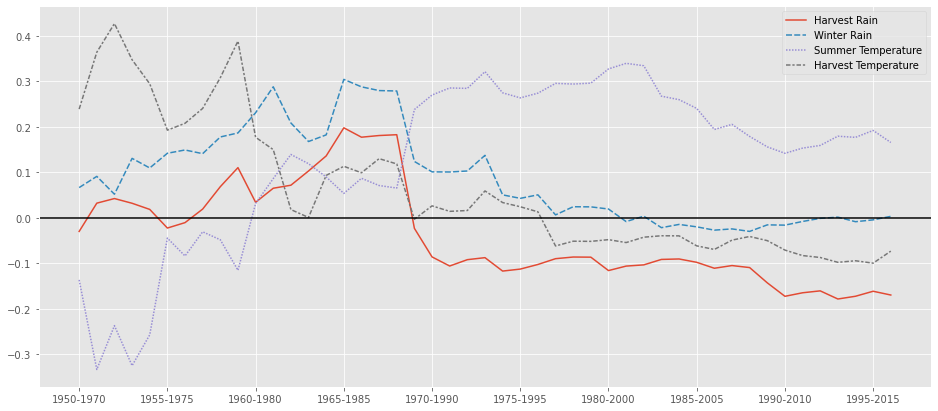

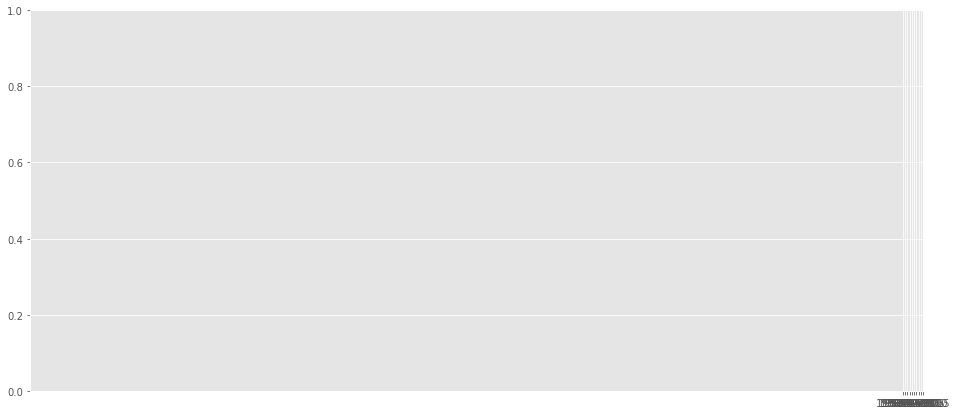

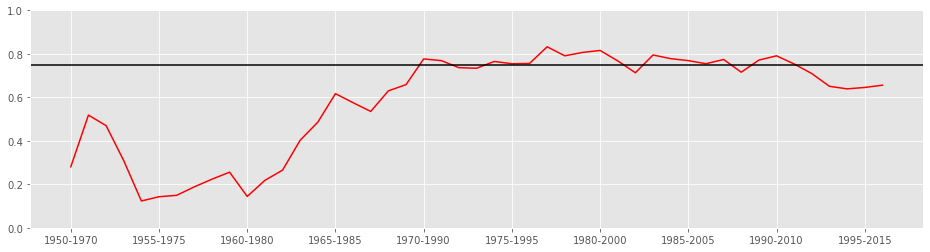

Average in-sample R2 score over the whole period:  -0.8090507359103783
Average in-sample spearman score over the whole period:  0.5831997789444597
Average out-sample Spearman R over the whole period:  0.5232337600758652


In [32]:
coefficients, r2_scores, spearman_scores, predictions = model_tester(X,y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:5]).axhline(0., color='black')
plt.xticks(range(1950,1996,5),labels=labels)
plt.show()

plt.figure(figsize=(16,7))
#sns.lineplot(data=coefficients.iloc[:,5:]).axhline(0., color='black')
plt.xticks(range(1950,1996,5),labels=labels)
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(spearman_scores, color='red')
plt.axhline(0.75, color='black')
plt.ylim((0,1))

plt.xticks(range(0,46,5),labels=labels)
plt.show()
print('Average in-sample R2 score over the whole period: ',np.mean(r2_scores))
print('Average in-sample spearman score over the whole period: ',np.mean(spearman_scores))

print('Average out-sample Spearman R over the whole period: ',spearmanr(predictions.loc[1981:2017], y.loc[1981:2017])[0])

# Can it predict prices?

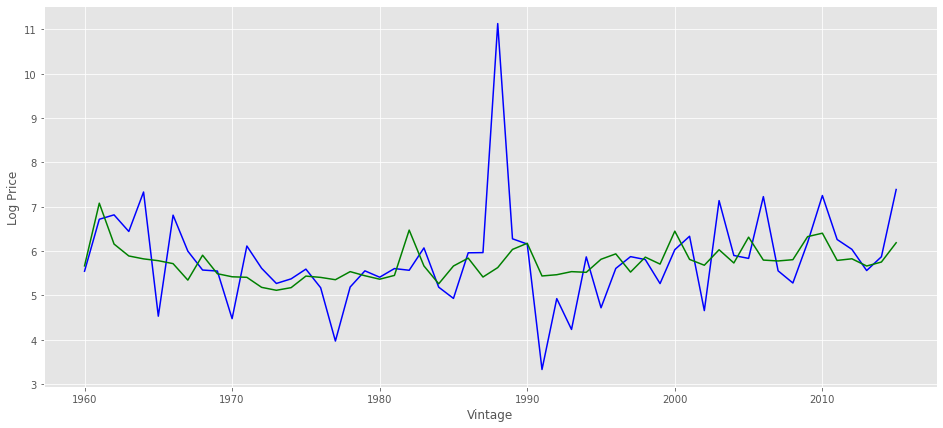

In [179]:
def reg_predict(X,y, window_length):
    coefficients = pd.DataFrame(0, index = ['Year']+X.columns.to_list(), columns=range(1950,1985))
    predictions = []

    X = pd.DataFrame(StandardScaler().fit_transform(X), index=X.index, columns=X.columns)

    for target_vintage in range(1950+window_length,2016):
        oldest_vintage = target_vintage - window_length
        newest_vintage = target_vintage

        y_ex = y.loc[oldest_vintage:newest_vintage-1,'Log Price'].reset_index(drop=True)
        X_ex = X.loc[oldest_vintage:newest_vintage-1,:].reset_index()
        model.fit(X_ex,y_ex)

        target = np.array([target_vintage]+X.loc[target_vintage,:].to_list()).reshape(1,-1)
        prediction = model.predict(target)
        predictions.append(prediction)
    return predictions
    
window_length = 10
plt.figure(figsize=(16,7))
plt.plot(range(1950+window_length,2016), reg_predict(X,y, window_length), color='blue')
sns.lineplot(data=y.loc[1950+window_length:2015,'Log Price'], color='green')
plt.show()

Let us compare the r2 score of our model, regression with a window of width n against the r2 score of a simple model that draws a regression line on the last n prices and simply continues that line to predict the next price.

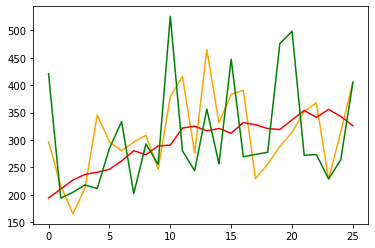

[-2.3450075073671157, -0.5703590083914978, -0.6028129399571327, -0.38768197967616835, -0.2666032947396917, -0.330468441251597, -0.32831633936196813, -0.33116771106165155, -0.1303322137066958, -0.010879199600015266, -0.05029274707129994, 0.09666031079641324, 0.05063269064892384, 0.03522393004795965, 0.016595094073112437, -0.0968035677616852, 0.006308146161686845, 0.08302870275128305, 0.050535286583141326, 0.009981925866179853, 0.04682124399681431, 0.09909078192505316, 0.025958460962042684, 0.0012502307594614015, -0.07201339000364104, -0.07899423032389419, -0.082441338489041, -0.09202823051342479]


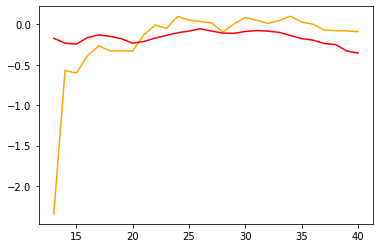

Maximal score:  0.09909078192505316


In [71]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

scores=[]
other_scores=[]
line_regressor = LinearRegression()

for window_length in range(13,41,1):
    prediction = np.exp(reg_predict(X,y, window_length))
    prediction = np.array(prediction.reshape(1,-1).tolist()[0][-26:]).reshape(1,-1)[0]
    actual_prices = np.exp(y.loc[1990:2015,'Log Price']).values

    line_model_predictions = np.zeros_like(actual_prices)
    
    for vintage in range(1990,2016):
        X_ex = np.array(X.loc[(vintage - window_length):(vintage -1)].index.to_list()).reshape(-1,1)
        y_ex = y.loc[(vintage - window_length):(vintage -1),'Log Price']
        line_regressor.fit(X_ex, y_ex)
        target = np.array([vintage]).reshape(1,-1)
        line_model_predictions[vintage-1990] = line_regressor.predict(target)

    line_model_predictions = np.exp(line_model_predictions)
    if window_length==30:
        plt.plot(prediction, color='orange')
        plt.plot(line_model_predictions, color='red')
        plt.plot(actual_prices, color='green')
        plt.show()
    scores.append(r2_score(actual_prices, prediction))
    other_scores.append(r2_score(actual_prices, line_model_predictions))

print(scores)
plt.plot(range(13,41,1),scores, color='orange')
plt.plot(range(13,41,1),other_scores, color='red')

plt.show()
print('Maximal score: ',max(scores))

According to the results, let us keep a window length of 30.
Now, try to quantify the predictive performance of this algo across the last 50 years.

36


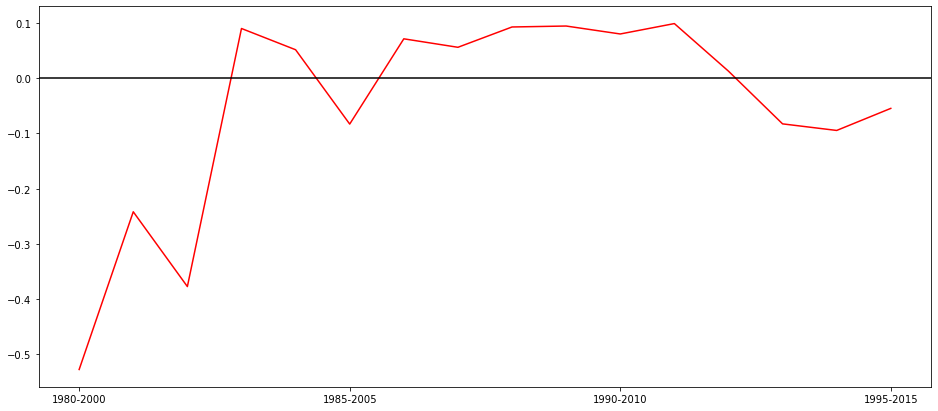

36 -0.15590144707037568


In [82]:
window_length=30

predictions = np.exp(reg_predict(X,y, window_length))
actual_prices = np.exp(y.loc[1980:2015,'Log Price']).values
print(len(predictions))
r2_scores=[]
for i in range(16):
    r2_scores.append(r2_score(actual_prices[i:(i+20)],predictions[i:(i+20)]))

plt.figure(figsize=(16,7))

labels = [str(i)+'-'+str(i+20) for i in range(1980,1996,5)]
plt.xticks(range(0,16,5),labels=labels)

sns.lineplot(x=range(16), y=r2_scores, color='red').axhline(0., color='black')
plt.show()

print(len(predictions), r2_score(actual_prices, predictions))

# Appendix: Trying PCA

In [ ]:
#X = pd.concat([precipitations, insulation, temp_maximals, temp_minimals, frost_days], axis=1)

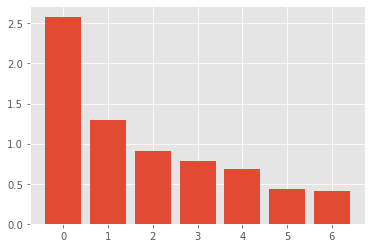

[[ 0.00148496  0.1823166  -0.40995284 -0.47238001 -0.48891618  0.35182072
   0.46123465]
 [ 0.66284562  0.58330954  0.27231869 -0.14852108 -0.19815165 -0.10746519
  -0.27084468]
 [-0.38084442  0.07182367  0.54358091 -0.16643607 -0.10573398  0.64383768
  -0.31766506]
 [-0.54102037  0.7676433  -0.14922148  0.21887287  0.11337137 -0.18082246
   0.04794276]
 [ 0.34909971  0.15091491 -0.17511899  0.494176    0.37564402  0.62945274
   0.20774582]
 [ 0.00675413  0.01239159  0.63120207  0.1939628  -0.13171873 -0.14406993
   0.72502223]
 [ 0.03117285  0.09563941  0.10464811 -0.63036563  0.7343064  -0.02197287
   0.2046475 ]]


In [190]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA(n_components=7)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

pipeline.fit(X.dropna(axis=0))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.show()
print(pca.components_)

X = X.dropna(axis=0)
X2 = pd.DataFrame(pca.transform(X), index=X.index)

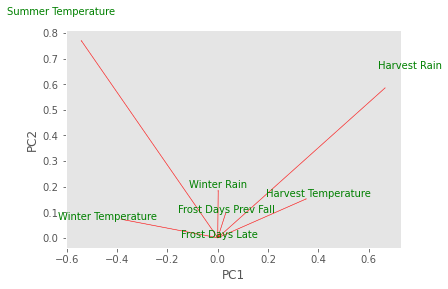

In [195]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    #plt.scatter(xs ,ys) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
myplot(X2.values[:,0:2], pca.components_, list(X.columns)) 
plt.show()

In [ ]:
coefficients, scores = model_tester(X2,y)

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,:5]).axhline(0., color='black')
plt.show()

plt.figure(figsize=(16,7))
sns.lineplot(data=coefficients.iloc[:,5:]).axhline(0., color='black')
plt.show()
   
plt.figure(figsize=(16,4))
plt.plot(scores, color='red')
plt.show()
print('Average score over the whole period: ',np.mean(scores))

PCA doesn't give good enough results, provided that it makes us lose track of the variables' meanings. We will not use it.

# Appendix: quadratic effects